In [30]:
from src.utilities import predict_and_save, split_data, get_method_name, score_method
from src.preprocess import process_missing_values, main_preprocess, create_entity
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
import lightgbm as lgb
import pandas as pd

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")


GLOBAL = {
    "save_cox": False,
    "save_xgb": True,
    "save_lgbm": False,
    "save_rsf": False,
    "save_shap": False
}

PARAMS = {
    "size": 0.70,
    "clinical": ["CYTOGENETICS"],#["CYTOGENETICS"], # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"] ["BM_BLAST+WBC", "BM_BLAST/HB", "HB*PLT", "HB/num_trisomies"]
    #"additional": ["default"],
    "molecular": ["GENE"],#["END-START"], # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
    "merge": ["featuretools", "gpt"], # Possible: ["featuretools", "gpt"]
    "xgb": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'subsample': 0.5,
        'max_features': None,
        'random_state': 42
    },
    "lgbm": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'verbose': 0
    },
    "rsf": {
    'n_estimators':260,  # Nombre d'arbres dans la forêt
    'max_depth':2,
    'min_samples_split':60,  # Nombre minimum d'échantillons requis pour splitter un nœud
    'min_samples_leaf':40,  # Nombre minimum d'échantillons par feuille
    'max_features':None,  # Sélection aléatoire des features
    'n_jobs':-1,  # Utilisation de tous les cœurs disponibles
    }
}


data = create_entity(PARAMS)

data = main_preprocess(data, PARAMS)
X, X_eval, y = split_data(data)

# Check if there are any columns that are not float or int in X
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - PARAMS['size']), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")
# Ensure all columns in X_train are either float or int

##############################################
# Define the methods used for training
##############################################

size_method = get_method_name("size", PARAMS)
clinical_method = get_method_name("clinical", PARAMS)
molecular_method = get_method_name("molecular", PARAMS)
merge_method = get_method_name("merge", PARAMS)

##############################################
# Fit a Gradient Boosting model
##############################################

xgb_params_method = "_".join([(str(key) + "=" + str(PARAMS['xgb'][key])) for key in PARAMS['xgb'].keys()])

xgb = GradientBoostingSurvivalAnalysis(**PARAMS['xgb'])
xgb.fit(X_train, y_train)
xgboost_score_method = score_method(xgb, X_train, X_test, y_train, y_test)

if GLOBAL["save_xgb"]:#clinical_method
    predict_and_save(X_eval, xgb, method=f"{size_method}-{xgboost_score_method}--{molecular_method}-{merge_method}-{xgb_params_method}")


Index(['gene_ASXL1', 'gene_BCOR', 'gene_BCORL1', 'gene_BRCC3', 'gene_CBL',
       'gene_CEBPA', 'gene_CSF3R', 'gene_CTCF', 'gene_CUX1', 'gene_DDX41',
       ...
       'SKEW(molecular.START)', 'SKEW(molecular.VAF)', 'STD(molecular.DEPTH)',
       'STD(molecular.END)', 'STD(molecular.START)', 'STD(molecular.VAF)',
       'SUM(molecular.DEPTH)', 'SUM(molecular.END)', 'SUM(molecular.START)',
       'SUM(molecular.VAF)'],
      dtype='object', length=102)
GradientBoostingSurvivalAnalysis Model Concordance Index IPCW on train: 0.760
GradientBoostingSurvivalAnalysis Model Concordance Index IPCW on test: 0.704


In [ ]:
df

In [31]:
import numpy as np
import pandas as pd
import shap

def predict_function(data):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_train.columns)
    return xgb.predict(data)

# 2) Create the SHAP Explainer using that function and a background dataset
explainer = shap.Explainer(predict_function, X_train)

# Assurez-vous que X_train est un DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)
shap_values = explainer.shap_values(X_train)

PermutationExplainer explainer: 2222it [03:01, 11.62it/s]                          


In [1]:
pd.Series(np.abs(shap_values).mean(0)).sort_values(ascending=False)

NameError: name 'pd' is not defined

In [28]:
pd.Series(np.abs(shap_values).mean(0)).sort_values(ascending=False)

58    0.220184
54    0.181544
52    0.171912
59    0.158359
36    0.097835
        ...   
32    0.000000
33    0.000000
37    0.000000
40    0.000000
3     0.000000
Length: 72, dtype: float64

In [41]:
import math

pd.Series(np.abs(shap_values).mean(0)).skew()

3.705394748744342

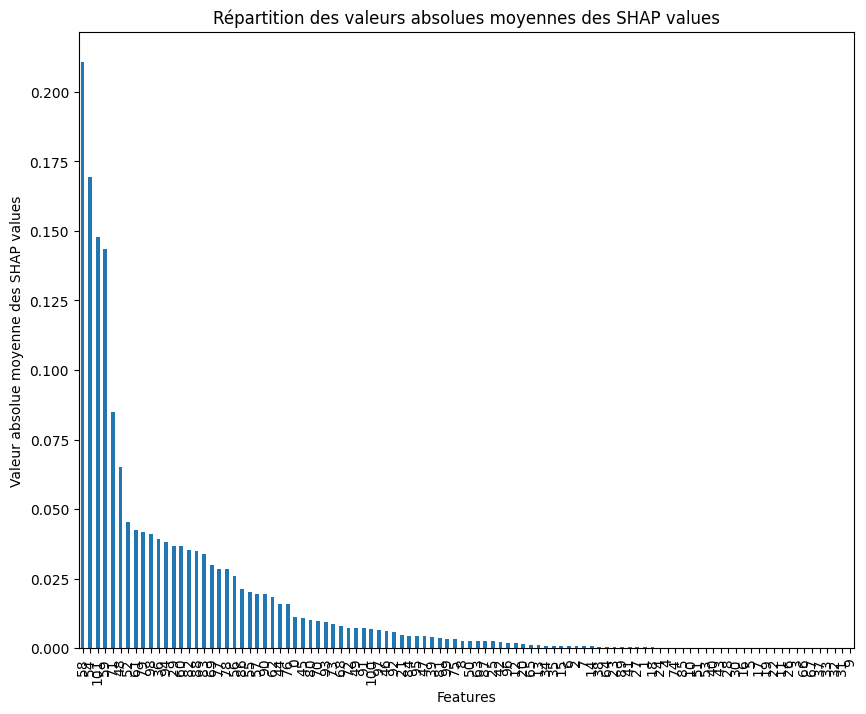

In [42]:
import matplotlib.pyplot as plt

# Calculer les valeurs absolues moyennes des SHAP values
mean_abs_shap_values = np.abs(shap_values).mean(0)

# Créer une série pandas pour faciliter le traçage
shap_series = pd.Series(mean_abs_shap_values)

# Tracer le graphique en barres
plt.figure(figsize=(10, 8))
shap_series.sort_values(ascending=False).plot(kind='bar')
plt.title('Répartition des valeurs absolues moyennes des SHAP values')
plt.ylabel('Valeur absolue moyenne des SHAP values')
plt.xlabel('Features')
plt.show()

In [37]:
np.abs(shap_values).mean(0)

array([1.13296979e-02, 3.59725780e-04, 7.46897279e-04, 0.00000000e+00,
       1.84422096e-04, 0.00000000e+00, 7.66310568e-04, 7.44049855e-04,
       2.74833572e-03, 0.00000000e+00, 2.39957959e-07, 0.00000000e+00,
       2.01608499e-03, 1.13145843e-03, 6.44181530e-04, 7.74375370e-04,
       0.00000000e+00, 0.00000000e+00, 2.67199466e-04, 0.00000000e+00,
       1.58950145e-03, 4.60780078e-03, 0.00000000e+00, 4.42977475e-04,
       1.95524507e-04, 2.54927001e-03, 0.00000000e+00, 3.92595903e-04,
       2.66619954e-08, 3.67867116e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.96238760e-04, 7.74954507e-04,
       3.92355922e-02, 0.00000000e+00, 5.88279570e-04, 4.12243969e-03,
       7.99859862e-08, 3.94488681e-04, 2.10595809e-03, 7.99859862e-08,
       1.60630978e-02, 1.08055443e-02, 6.25181549e-03, 4.32459657e-03,
       6.50662928e-02, 7.24915477e-03, 2.62112173e-03, 2.13295963e-07,
       4.52463522e-02, 1.39679887e-07, 1.69452968e-01, 2.01220508e-02,
      

In [33]:
np.abs(shap_values).mean()

0.016377889891444893

In [9]:
import pandas as pd

# Récupération des importances de chaque feature
importances = xgb.feature_importances_
features = X.columns

# Mise dans un DataFrame pour trier selon l'importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importance_df)

         feature  importance
54      BM_BLAST    0.134982
58            HB    0.121049
59           PLT    0.095672
52  unique_genes    0.087553
36     gene_TP53    0.065459
..           ...         ...
19    gene_KMT2C    0.000000
30   gene_SETBP1    0.000000
3     gene_BRCC3    0.000000
28   gene_PTPN11    0.000000
37    gene_U2AF1    0.000000

[72 rows x 2 columns]


In [10]:
importance_df

feature       BM_BLASTHBPLTunique_genesgene_TP53complexity_s...
importance                                                  1.0
dtype: object

In [13]:
importance_df['importance'].sum()

1.0000000000000002

In [4]:
# Fait une lsite des features à 0
zero_importance = importance_df[importance_df['importance'] == 0]['feature'].tolist()

NameError: name 'importance_df' is not defined

In [4]:
importance_df[:50].reset_index().drop(columns=['index'])

,feature,importance
0,BM_BLAST,0.119994
1,HB,0.116135
2,PLT,0.088400
3,VAF_sum,0.071143
4,complexity_score,0.051440
5,START_min,0.036480
6,gene_TP53,0.032282
7,DEPTH_std,0.026943
8,gene_RUNX1,0.025430
9,GENE_nunique,0.025361


In [10]:
importance_df[:50].reset_index().drop(columns=['index'])

,feature,importance
0,BM_BLAST,0.119233
1,HB,0.113489
2,PLT,0.085511
3,SUM(molecular.VAF),0.071459
4,complexity_score,0.050800
5,END_min,0.030111
6,gene_TP53,0.026967
7,AA_position_mean,0.026392
8,VAF_sum,0.025416
9,num_monosomies,0.022724


In [19]:
data = create_entity()

data['molecular']

,index,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,0,P100000,11,119149248,119149248,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308
1,1,P100000,5,131822301,131822301,G,T,IRF1,p.Y164*,stop_gained,0.0220,532
2,2,P100000,3,77694060,77694060,G,C,ROBO2,p.?,splice_site_variant,0.4100,876
3,3,P100000,4,106164917,106164917,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826
4,4,P100000,2,25468147,25468163,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942
...,...,...,...,...,...,...,...,...,...,...,...,...
14019,14019,KYW1077,NaN,<NA>,<NA>,NaN,NaN,MLL,MLL_PTD,PTD,0.4231,<NA>
14020,14020,KYW1084,NaN,<NA>,<NA>,NaN,NaN,MLL,MLL_PTD,PTD,0.0176,<NA>
14021,14021,KYW1082,NaN,<NA>,<NA>,NaN,NaN,MLL,MLL_PTD,PTD,0.2273,<NA>
14022,14022,KYW1085,NaN,<NA>,<NA>,NaN,NaN,MLL,MLL_PTD,PTD,0.2941,<NA>


<Axes: >

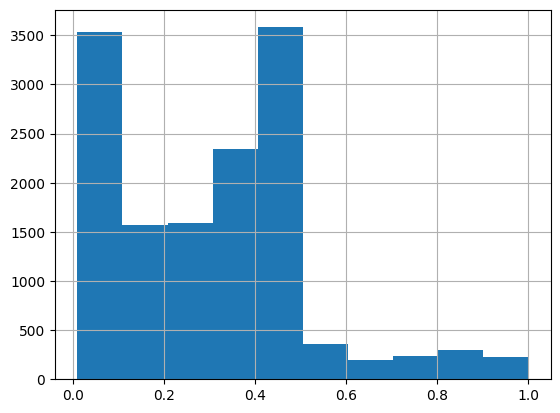

In [22]:
data['molecular']['VAF'].hist()

In [39]:
data['molecular'].loc[data['molecular']['ID'] == 'P132697']['VAF'].sum()

2.2642

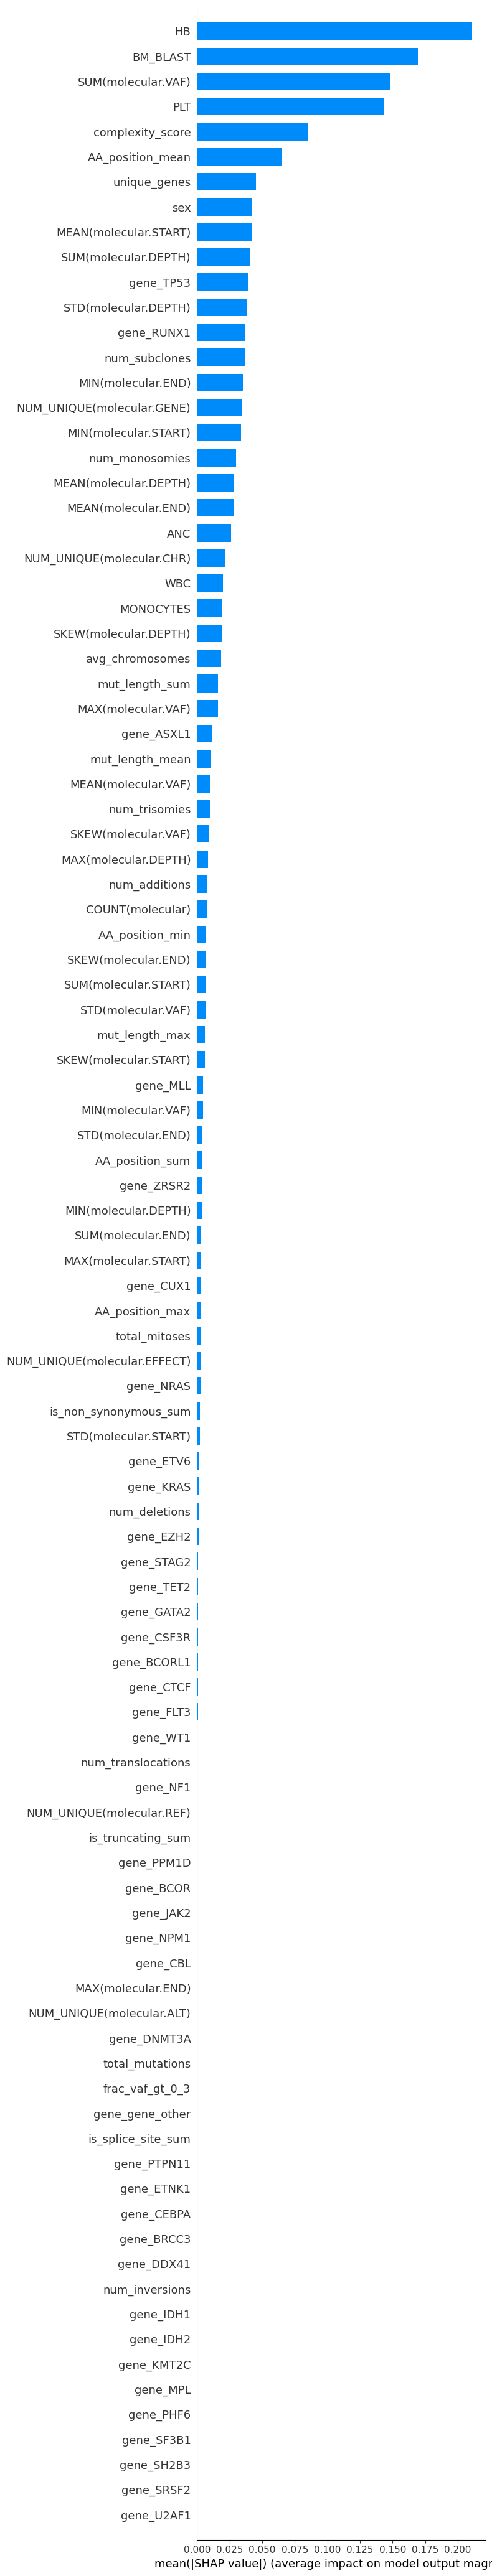

In [34]:
fig = shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=100)

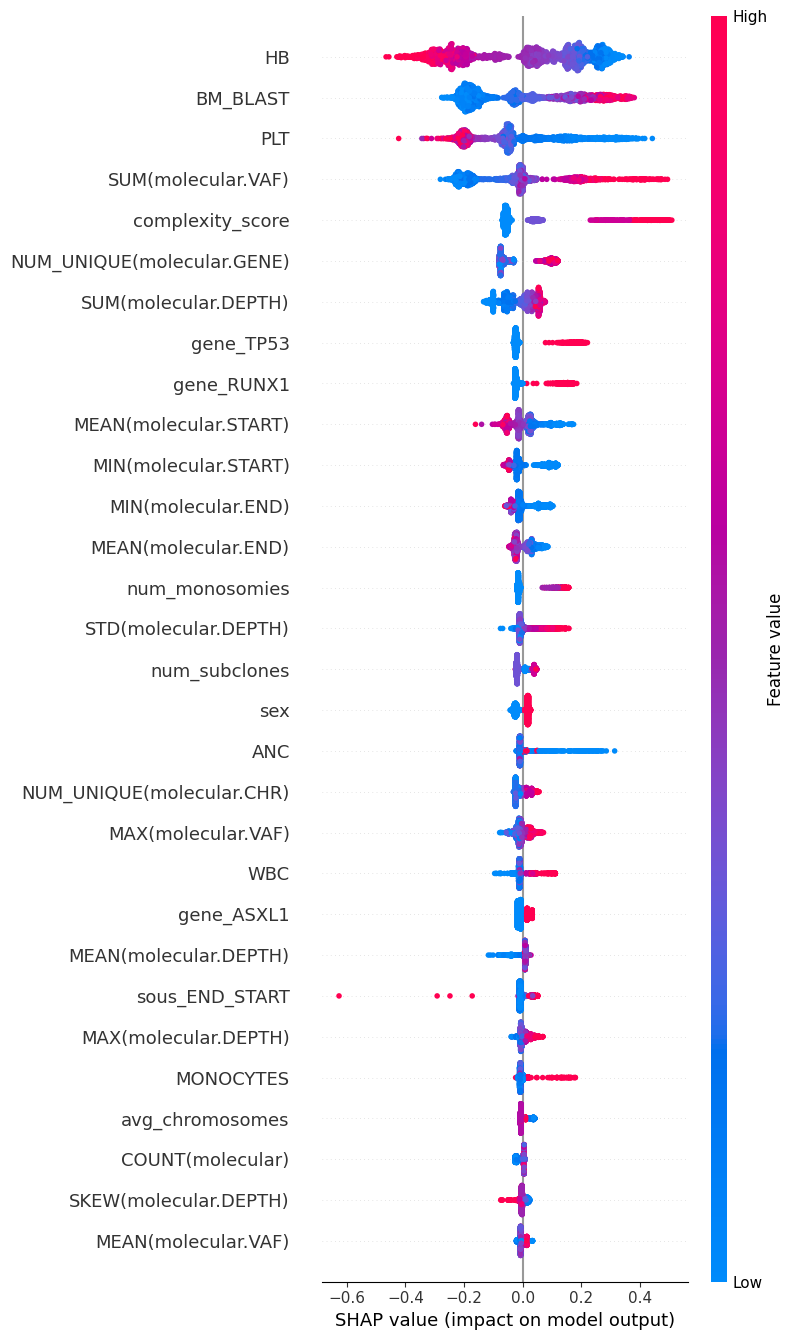

In [6]:
shap.summary_plot(shap_values, X_train, max_display=30)

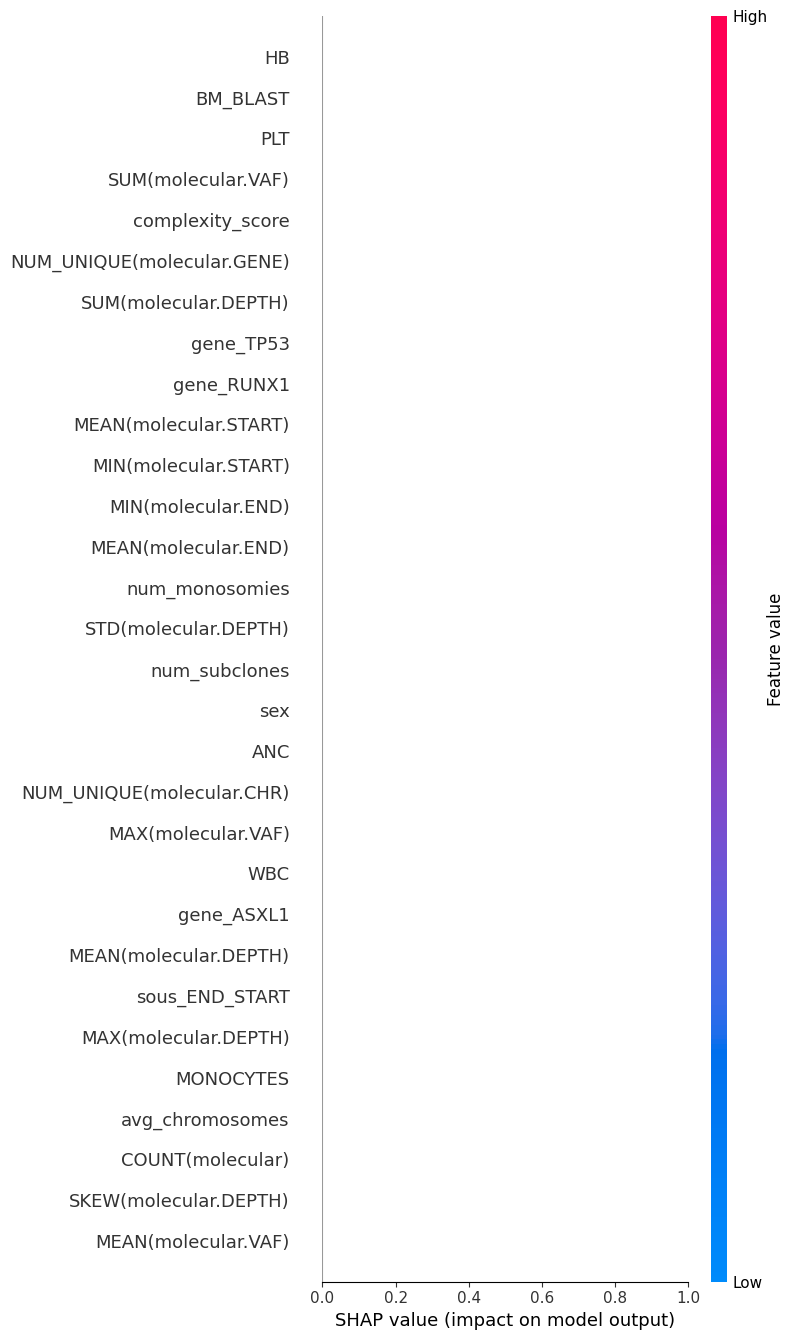

In [8]:
shap.summary_plot(shap_values, X_train, plot_type="scatter", max_display=30)

In [ ]:
import os
import io
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap


X_train = pd.DataFrame(X_train, columns=X.columns)

class ShapReport:
    def __init__(self, model, X_train, predict_function=None, nb_features=len(X_train.columns)):
        """
        :param model: Le modèle dont on veut expliquer les prédictions.
        :param X_train: Le jeu de données d'arrière-plan (pandas DataFrame).
        :param predict_function: Fonction de prédiction. Si None, on utilise model.predict.
        """
        self.model = model
        self.X_train = X_train.copy()
        if predict_function is None:
            self.predict_function = model.predict
        else:
            self.predict_function = predict_function
        self.nb_features = nb_features

        # Création de l'explainer SHAP à partir de la fonction de prédiction et du jeu de données
        self.explainer = shap.Explainer(self.predict_function, self.X_train)
        self.shap_values = self.explainer(self.X_train)

    def _fig_to_base64(self, fig):
        """Convertit une figure matplotlib en chaîne base64."""
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        plt.close(fig)
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        return img_str

    def generate_report(self, output_html="shap_report.html"):
        """
        Génère un rapport SHAP HTML en enregistrant plusieurs graphiques.
        
        :param output_html: Chemin du fichier HTML généré.
        """
        plots = {}

        # 1. Summary Plot (bar)
        plt.figure()
        shap.summary_plot(self.shap_values, self.X_train, plot_type="bar", show=False, max_display=self.nb_features)
        fig_bar = plt.gcf()
        plots['summary_bar'] = self._fig_to_base64(fig_bar)

        # 2. Summary Plot (dot)
        plt.figure()
        shap.summary_plot(self.shap_values, self.X_train, show=False, max_display=self.nb_features)
        fig_dot = plt.gcf()
        plots['summary_dot'] = self._fig_to_base64(fig_dot)

        # 3. Dependence Plots pour les 5 meilleures variables
        # On sélectionne les 5 variables dont la moyenne des valeurs absolues de SHAP est la plus élevée.
        mean_abs_shap = np.abs(self.shap_values.values).mean(axis=0)
        # On trie les indices par ordre décroissant
        top_feature_indices = np.argsort(mean_abs_shap)[::-1][:10]
        top_features = self.X_train.columns[top_feature_indices]

        # Dictionnaire pour stocker les images encodées des dependence plots
        for feature in top_features:
            plt.figure()
            shap.dependence_plot(feature, self.shap_values.values, self.X_train, show=False)
            fig_dep = plt.gcf()
            # On enregistre l'image dans le dictionnaire en utilisant le nom de la feature comme clé
            plots[f'dependence_{feature}'] = self._fig_to_base64(fig_dep)

        # # Création du template HTML final
        # # On construit une section HTML pour chacun des dependence plots
        # dependence_plots_html = ""
        # for feature in top_features:
        #     dependence_plots_html += f"""
        #         <div class="plot">
        #             <h2>Dependence Plot pour la variable : {feature}</h2>
        #             <img src="data:image/png;base64,{plots['dependence_' + feature]}" alt="Dependence Plot pour {feature}">
        #         </div>
        #     """

        # html_template = f"""
        # <!DOCTYPE html>
        # <html>
        # <head>
        #     <meta charset="UTF-8">
        #     <title>Rapport SHAP</title>
        #     <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        #     {shap.getjs()}
        #     <style>
        #         body {{
        #             font-family: Arial, sans-serif;
        #             margin: 20px;
        #         }}
        #         h1, h2 {{
        #             color: #333;
        #         }}
        #         .plot {{
        #             margin-bottom: 50px;
        #         }}
        #         img {{
        #             max-width: 100%;
        #             height: auto;
        #             border: 1px solid #ddd;
        #             padding: 5px;
        #             background: #f9f9f9;
        #         }}
        #     </style>
        # </head>
        # <body>
        #     <h1>Rapport SHAP</h1>
        #     <div class="plot">
        #         <h2>Summary Plot (Bar)</h2>
        #         <img src="data:image/png;base64,{plots['summary_bar']}" alt="Summary Plot Bar">
        #     </div>
        #     <div class="plot">
        #         <h2>Summary Plot (Dot)</h2>
        #         <img src="data:image/png;base64,{plots['summary_dot']}" alt="Summary Plot Dot">
        #     </div>
        #     {dependence_plots_html}
        # </body>
        # </html>
        # """

        # Création du template HTML final avec trois colonnes
        dependence_plots_html = ""
        for feature in top_features:
            dependence_plots_html += f"""
                <div class="plot">
                    <h2>Dependence Plot pour la variable : {feature}</h2>
                    <img src="data:image/png;base64,{plots['dependence_' + feature]}" alt="Dependence Plot pour {feature}">
                </div>
            """

        html_template = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <meta charset="UTF-8">
            <title>Rapport SHAP</title>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            {shap.getjs()}
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 20px;
                }}
                h1, h2 {{
                    color: #333;
                }}
                .container {{
                    display: flex;
                    flex-wrap: wrap;
                    gap: 20px;
                }}
                .column {{
                    flex: 1;
                    min-width: 300px;
                }}
                .plot {{
                    margin-bottom: 30px;
                }}
                img {{
                    max-width: 100%;
                    height: auto;
                    border: 1px solid #ddd;
                    padding: 5px;
                    background: #f9f9f9;
                }}
            </style>
        </head>
        <body>
            <h1>Rapport SHAP</h1>
            <div class="container">
                <!-- Colonne 1 : Summary Plot (Bar) -->
                <div class="column">
                    <div class="plot">
                        <h2>Summary Plot (Bar)</h2>
                        <img src="data:image/png;base64,{plots['summary_bar']}" alt="Summary Plot Bar">
                    </div>
                </div>
                <!-- Colonne 2 : Summary Plot (Dot) -->
                <div class="column">
                    <div class="plot">
                        <h2>Summary Plot (Dot)</h2>
                        <img src="data:image/png;base64,{plots['summary_dot']}" alt="Summary Plot Dot">
                    </div>
                </div>
                <!-- Colonne 3 : Dependence Plots -->
                <div class="column">
                    {dependence_plots_html}
                </div>
            </div>
        </body>
        </html>
        """

        # Enregistrement du rapport HTML
        with open(output_html, "w", encoding="utf-8") as f:
            f.write(html_template)
        print(f"Le rapport SHAP a été sauvegardé dans : {output_html}")

# Exemple d'utilisation :
# --------------------------------------------------
# Supposons que 'xgb' est votre modèle XGBoost déjà entraîné,
# et que 'X_train' est votre DataFrame d'entraînement.

# Définition d'une fonction de prédiction (adaptée à votre cas)
def predict_function(data):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_train.columns)
    return xgb.predict(data)

# Création de l'explainer SHAP (si vous souhaitez l'utiliser séparément)
# explainer = shap.Explainer(predict_function, X_train)
# shap_values = explainer(X_train)

# Création du rapport via la classe
report = ShapReport(model=xgb, X_train=X_train, predict_function=predict_function, nb_features=len(X_train.columns))


PermutationExplainer explainer: 2222it [01:21, 23.81it/s]                          


In [ ]:
report.generate_report("mon_rapport_shap.html", open_in_browser=True)